## This is an example of how to use Hierarchical Agglomerative Clustering Method for Cluster Analysis of quantitative data, using Python, Pandas, NumPy, SciPy, Scikit-learn, Pingouin, Matplotlib, Seaborn and Plotly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pingouin as pg
import plotly.express as px
import os
import plotly.io as pio
if os.getenv("GITHUB_ACTIONS") == "true":
    pio.renderers.default = "png"
else:
    pio.renderers.default='colab'

- the formulas shown at this notebook have been taken from the following reference:

    FÁVERO, L. P.; BELFIORE, P. Manual de Análise de Dados: Estatística e Machine Learning com Excel®, SPSS®, Stata®, R® e Python®. 2ª edição, 1288 p. Brasil: ccGEN LTC, 2024.
    
    Available in Brazil at:
    
    https://www.amazon.com.br/Manual-An-C3-A1lise-Dados-Estat-C3-ADstica-Learning-dp-8595159920/dp/8595159920

## Use Case Scenario and Data - Stores' Branches Evaluation

In this sample use case, there are 14 store branches that are being evaluated based on client feedbacks regarding the attending customer service, the assortment of items and the organization perceived by the client. For each of these features (quantitative data), we have the average score (grade) clients gave to each branch as our dataset. We want to proceed Cluster Analysis on this data in order to segment (clusterize) the branches according to data patterns not yet known to the administration, so that strategic decisions can be made in order to improve quality and value to the client.

In [2]:
# reading and displaying our dataset
# store and region are qualitative labels that identify a store, it is not a quantitative variable, thus it shouldn't be used at 
# the clustering calculation, just at the initial and final output views.
retailer_data = pd.read_excel("regional_retailer.xlsx")
retailer_data_without_store_region = retailer_data.drop(columns=["STORE","REGION"])
retailer_data

,STORE,REGION,SERVICE,ASSORTMENT,ORGANIZATION
0,1,Region 3,6,6,4
1,2,Region 3,14,2,4
2,3,Region 3,8,4,6
3,4,Region 3,4,4,4
4,5,Region 3,6,6,6
5,6,Region 2,38,38,100
6,7,Region 1,40,78,38
7,8,Region 3,6,4,4
8,9,Region 3,4,4,6
9,10,Region 3,6,6,2


In [3]:
retailer_data_without_store_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SERVICE       18 non-null     int64
 1   ASSORTMENT    18 non-null     int64
 2   ORGANIZATION  18 non-null     int64
dtypes: int64(3)
memory usage: 564.0 bytes


In [4]:
retailer_data_without_store_region.describe()

,SERVICE,ASSORTMENT,ORGANIZATION
count,18.000000,18.000000,18.000000
mean,28.111111,27.888889,33.111111
std,27.003026,30.497616,37.247801
min,2.000000,2.000000,2.000000
25%,6.000000,4.000000,4.000000
50%,11.000000,6.000000,6.000000
75%,52.000000,51.500000,55.000000
max,78.000000,86.000000,100.000000


In [5]:
# we can plot and see the observations as below - better compatibility with cloud .ipynb running, and works fine locally as well:
import plotly.graph_objects as go
fig = go.Figure()

# ---------- Store scatter ----------
fig.add_trace(go.Scatter3d(
    x=retailer_data["SERVICE"],
    y=retailer_data["ASSORTMENT"],
    z=retailer_data["ORGANIZATION"],
    mode='markers+text',
    text=retailer_data["STORE"],
    textposition='top center',
    textfont=dict(size=10),
    name="Store",
    marker=dict(size=3, color="blue")
))

# ---------- Layout ----------
fig.update_layout(
    title=dict(
        text="Store Customer Feedback (1-100) - Initial Data Visualization ",
        subtitle=dict(
            text="(3D Space: Attendance Service × Assortment × Organization)",
            font=dict(size=11)
        ),
        x=0.5,
        xanchor='center',
        font=dict(size=14),
        pad=dict(t=0, b=0)
    ),
    legend=dict(
        itemsizing='constant',
        font=dict(size=11)
    ),
    showlegend=True,
    scene=dict(
        xaxis=dict(title=dict(text="SERVICE",font=dict(size=10)),tickfont=dict(size=9)),
        yaxis=dict(title=dict(text="ASSORTMENT",font=dict(size=10)),tickfont=dict(size=9)),
        zaxis=dict(title=dict(text="ORGANIZATION",font=dict(size=10)),tickfont=dict(size=9))
    ),
    width=600,
    height=500,
    margin=dict(
        l=80,
        r=80,
        t=90,
        b=50
    )
)

# ---------- Save ----------
fig.write_html('retailer_initial.html')
fig.show()

## Hierarchical Agglomerative Clustering Method

In [6]:
# creating and showing the dissimilarity matrix for the distance type "euclidean" between the 18 stores, taken 2 at a time. We 
# don't have to create this matrix explicitly, as, implicitly, it's already created when generating the clusters dendrogram. It's 
# useful though to have a view of the distances between each element's (store) values (from the variables service, assortment 
# and organization), as it is this distance between values that will be used to determine the sequence at each cluster combination 
# (for single, complete or average linkage types). The distance between stores 1 and 2, for instance, using euclidean distance 
# type, is calculated by the square root of the sum of squares of differences between each features' values of store 1 and 
# store 2 => 1-2 = sqroot((6-14)²+(6-2)²+(4-4)²) = 8.94427191. The same calculation is done for all possible combinations between 
# each two stores (and all their features' variables' values). This distance is later used at each phase of cluster formation, 
# always resulting in the aggregating of two observations (either isolated or previously clustered observations) according to the 
# shortest distance. There are many sorts of dissimilarity calculation measures, as well as of linkage types, but the aggregation, 
# ultimately, is always by clustering the shortest distance observations (based on the didssimilarity measure and linkage method 
# chosen). For the 18 observations (stores), we have 153 combinations, taken 2 at a time (repetitions and ordering disregarded).

distance_matrix_euclidean = pdist(retailer_data_without_store_region, metric="euclidean")
pd.DataFrame(data=[distance_matrix_euclidean], index=["EUCLIDEAN DIST"]).T

,EUCLIDEAN DIST
0,8.944272
1,3.464102
2,2.828427
3,2.000000
4,106.131993
...,...
148,23.409400
149,103.421468
150,83.474547
151,4.472136


In [7]:
# Having decided the method for calculating the dissimilarity distance between each isolated observation (and done the calculus), 
# we must proceed with the cluster formation phases. The aggregation of each two isolated observations between themselves or 
# between one isolated observation and a previous cluster (with more than one observation) is always done considering the shortest 
# distance. In the second case, though, we must also decide what to compare and what distance to consider, as we have more than one 
# observation in a same cluster being compared its distance to the distance of another cluster or isolated observation. In such a 
# case we must chose the linkage method: single linkage, complete linkage or average linkage. For each aggregation phase concluded, 
# we keep the distance considered for that chosen aggregation row - which is the aggregation cost, calculated according to the 
# chosen linkage method. This aggregation cost is not necessarily any of the values from the dissimilarity distance matrix, 
# although is derived from those (applied at the linkage method). Each dissimilarity distance is between two isolated observations 
# - always, while the distance considered as the aggregation cost may be between two clusters, a cluster and an isolated 
# observation or between two isolated observations as well. Each aggregation phase result, and aggregation distance for that 
# combination, then form the graphical dendrogram below.

\* see aggregation phasing thorough explanation at the other use case example, at this same project directory:<br>
[sample-ml-clustering-hierarchical-agglomerative-student(colab-version).ipynb](./sample-ml-clustering-hierarchical-agglomerative-student(colab-version).ipynb) <br>
The more observations we have, the harder would be to perform each aggregation manually, keeping each aggregation cost, all that based on the dissimilarity distances. So let us let the algorithms do it for us and simply show us the result, at a final dendrogram.

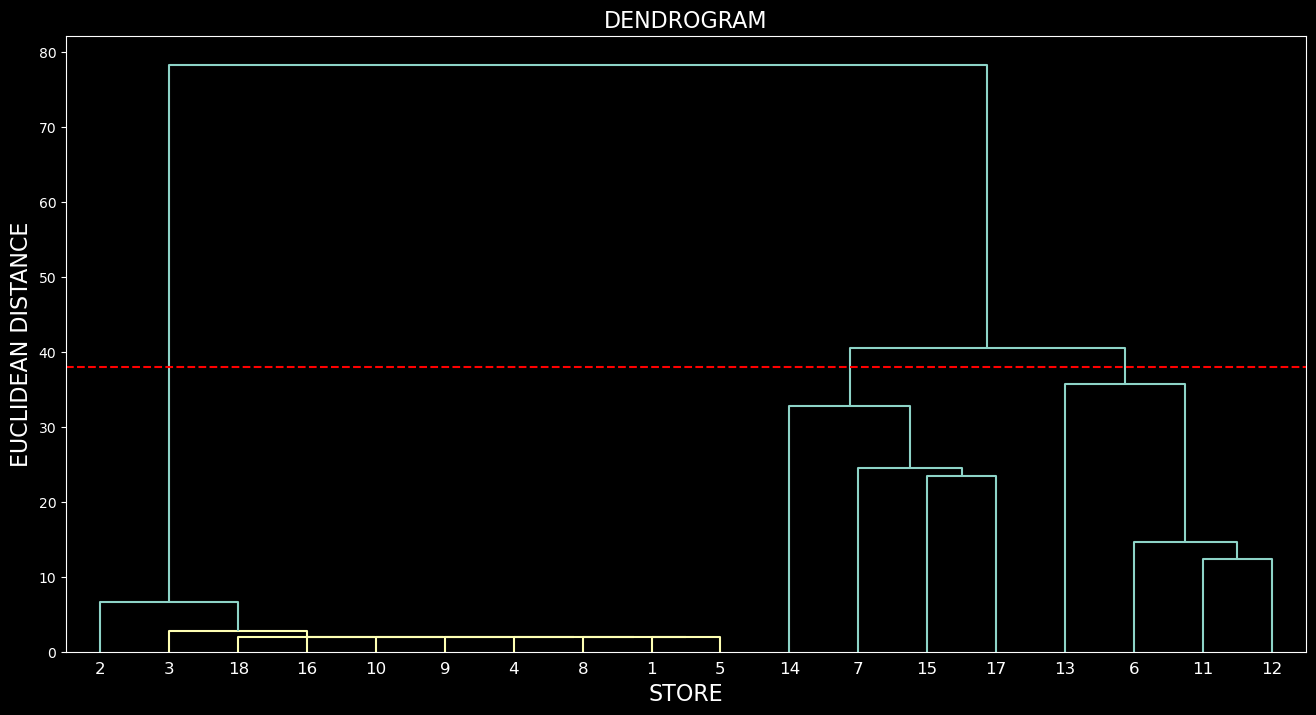

In [8]:
# performing the clustering (graphic solution) and plotting the dendrogram, after setting the distance and linkage type to be used
plt.figure(figsize=(16,8))
dendrogram_euclidean_metric_single_linkage_data_array = sch.linkage(retailer_data_without_store_region, method="single", metric="euclidean")
dendrogram_s = sch.dendrogram(dendrogram_euclidean_metric_single_linkage_data_array, color_threshold = 4.5, labels = list(retailer_data.STORE))
plt.title('DENDROGRAM', fontsize=16)
plt.xlabel('STORE', fontsize=16)
plt.ylabel('EUCLIDEAN DISTANCE', fontsize=16)
plt.axhline(y = 38, color = 'red', linestyle = '--')
plt.show()

In [9]:
# we could try other metric types (dissimilarity distance calculation types) and linkage methods to analyse different dendrograms, 
# although the result of the clustering should be the same or something very close

In [10]:
# at the dendrogram above, based on the distances, it's been evaluated as ideal, for this use case, that we should have 3 clusters, 
# defined by the dashed horizontal red line: [2,3,18,16,10,9,4,8,1,5], [14,7,15,17] and [13,6,11,12]. Eventual further aggregations 
# was considered to be too costly in terms of distance (between formed clusters). This decision is subjective, though, and more 
# than one solution could be considered right. As a common sense, if the distance to aggregate the next cluster is too big, we 
# stop the aggregation at that state... in this case, with 3 distinct clusters.

In [11]:
# performing the clustering (numerical solution) and adding a categorical (qualitative) variable to describe which cluster each 
# store belongs to. Although numerical, these are simply categorical labels (identifiers of each cluster). This is done after 
# we have already performed the aggregation and decided how many clusters we wish to keep independent from each other. Below we
# have clusters 0 (with stores 6,11,12,13), cluster 1 (with stores 1,2,3,4,5,8,9,10,16,18) and cluster 2 (with stores 7,14,15,17). 
# These are exactly the same clusters at the dendrogram above (the order is irrelevant).
cluster_indicator_generator = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'single')
cluster_indicators_generated = cluster_indicator_generator.fit_predict(retailer_data_without_store_region)
retailer_data['CLUSTER_INDICATOR_SINGLE'] = cluster_indicators_generated
retailer_data['CLUSTER_INDICATOR_SINGLE'] = retailer_data['CLUSTER_INDICATOR_SINGLE'].astype('category')
retailer_data.sort_values("CLUSTER_INDICATOR_SINGLE")

,STORE,REGION,SERVICE,ASSORTMENT,ORGANIZATION,CLUSTER_INDICATOR_SINGLE
12,13,Region 2,76,60,88,0
11,12,Region 2,52,34,98,0
10,11,Region 2,54,32,86,0
5,6,Region 2,38,38,100,0
0,1,Region 3,6,6,4,1
15,16,Region 3,2,4,4,1
9,10,Region 3,6,6,2,1
8,9,Region 3,4,4,6,1
4,5,Region 3,6,6,6,1
3,4,Region 3,4,4,4,1


In [12]:
retailer_data.groupby("CLUSTER_INDICATOR_SINGLE", observed=True).agg(
    STORE=("STORE", list),
    AVG_SERVICE=("SERVICE", "mean"),
    AVG_ASSORTMENT=("ASSORTMENT", "mean"),
    AVG_ORGANIZATION=("ORGANIZATION", "mean"),
).reset_index().style.hide(axis="index")

CLUSTER_INDICATOR_SINGLE,STORE,AVG_SERVICE,AVG_ASSORTMENT,AVG_ORGANIZATION
0,"[6, 11, 12, 13]",55.000000,41.000000,93.000000
1,"[1, 2, 3, 4, 5, 8, 9, 10, 16, 18]",6.200000,4.200000,4.400000
2,"[7, 14, 15, 17]",56.000000,74.000000,45.000000


In [13]:
# distances where each cluster has been formed at the dendrogram (at each hierarchical agglomerative stage) (see dendrogram above)
[d[1] for d in dendrogram_s["dcoord"]]

[np.float64(2.0),
 np.float64(2.0),
 np.float64(2.0),
 np.float64(2.0),
 np.float64(2.0),
 np.float64(2.0),
 np.float64(2.0),
 np.float64(2.8284271247461903),
 np.float64(6.6332495807108),
 np.float64(23.40939982143925),
 np.float64(24.49489742783178),
 np.float64(32.802438933713454),
 np.float64(12.328828005937952),
 np.float64(14.696938456699069),
 np.float64(35.66510900025401),
 np.float64(40.496913462633174),
 np.float64(78.2559901860554)]

In [14]:
import plotly.graph_objects as go
import plotly.io as pio

fig = go.Figure()

# get unique clusters
clusters = retailer_data["CLUSTER_INDICATOR_SINGLE"].unique()

# loop through clusters and create a separate trace for each
for cluster in clusters:
    cluster_data = retailer_data[retailer_data["CLUSTER_INDICATOR_SINGLE"] == cluster]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data["SERVICE"],
        y=cluster_data["ASSORTMENT"],
        z=cluster_data["ORGANIZATION"],
        mode='markers+text',
        text=cluster_data["STORE"],
        textposition='top center',
        textfont=dict(size=10),
        name=f"Cluster {cluster}",
        marker=dict(
            size=4,
            color=cluster,
            colorscale='Rainbow',
            showscale=False
        )
    ))

fig.update_layout(
    title=dict(
        text="Store Customer Feedback (1-100) - Hierarchical Agglomerative Clustering - Final",
        subtitle=dict(
            text="(3D Space: Attendance Service × Assortment × Organization)",
            font=dict(size=11)
        ),
        x=0.5,
        xanchor='center',
        font=dict(size=14),
        pad=dict(t=0, b=0)
    ),
    legend=dict(
        itemsizing='constant',
        font=dict(size=11)
    ),
    showlegend=True,
    scene=dict(
        xaxis=dict(title=dict(text="SERVICE", font=dict(size=10)), tickfont=dict(size=9)),
        yaxis=dict(title=dict(text="ASSORTMENT", font=dict(size=10)), tickfont=dict(size=9)),
        zaxis=dict(title=dict(text="ORGANIZATION", font=dict(size=10)), tickfont=dict(size=9))
    ),
    width=600,
    height=500,
    margin=dict(l=80, r=80, t=90, b=50)
)

fig.write_html('retailer_final_hierarchical.html')
fig.show()


In [15]:
# Dissimilarity distances (according to each method chosen), as well as the variables' values, do not change when we use different 
# linkage methods. What may vary is the aggregation distance at each phase (the aggregation cost), the number of phases and the
# dendrogram and final matrix with the output of the clustering, as the clusters might be different in number and in elements 
# composing them.